#  **Model_Trials_02**  
(Classification Algorithms)
___

## Random Forest Classifer and Gradient Boosting Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint

In [2]:
#Load encoded set
enc_set = ("/Users/sa14/Desktop/fin eda final/data/Encoded_Set.csv")
df_model = pd.read_csv(enc_set)

#Sample 30% of bank data for initial training & hyperparameter tuning
sample_df = df_model.sample(frac=0.3, random_state=42) 

In [3]:
# Create a list of Features to be stored in "X"

# The Features list will not include "IsFraud" as that will be the target feature
X = df_model.drop(columns=["isFraud"])  

# Target: "isFraud" column
y = df_model["isFraud"] 

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, 
                                                    random_state=42, stratify=y)

# Set up Scaler then scale existing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
#Import SMOTE for this code block
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [5]:
#Get count of rows & columns for X_test and X_train
X_train.shape, X_test.shape

((5090096, 10), (1272524, 10))

In [7]:
# Define function to train, evaluate, and print results and visualization

def train_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', 
                xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return acc, f1


Bank Fraud Training Models with Default Parameters: 


Random Forest Performance:
Accuracy: 0.9997
F1 Score: 0.8716
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.97      0.79      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.89      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



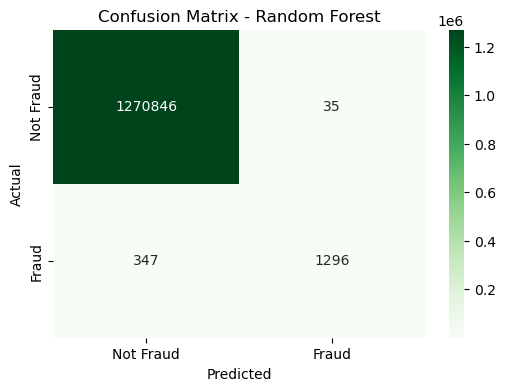


Gradient Boosting Performance:
Accuracy: 0.9989
F1 Score: 0.3741
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.69      0.26      0.37      1643

    accuracy                           1.00   1272524
   macro avg       0.84      0.63      0.69   1272524
weighted avg       1.00      1.00      1.00   1272524



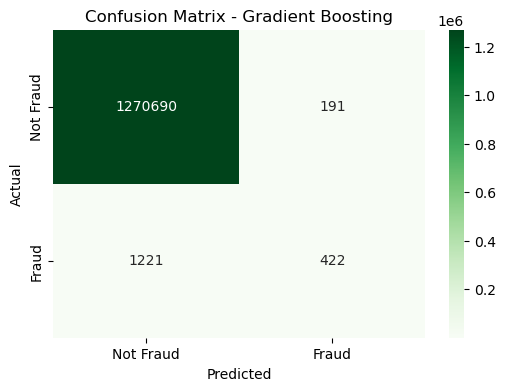


Best performing model: Random Forest


In [8]:
# Create empty dictionary to store model results
model_results = {}

# Train models with default parameters to find the best one
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

print("\nBank Fraud Training Models with Default Parameters: \n")
for name, model in models.items():
    acc, f1 = train_evaluate_model(model, name)
    model_results[name] = {'Accuracy': acc, 'F1 Score': f1}

    # Determine best model based on F1 Score
best_model_name = max(model_results, key=lambda k: model_results[k]['F1 Score'])
print(f"\nBest performing model: {best_model_name}")

# Define hyperparameter tuning for best model
param_grids = {
    "Random Forest": {'n_estimators': randint(50, 200), 'max_depth': randint(3, 20), 
                      'min_samples_split': randint(2, 10), 'min_samples_leaf': randint(1, 10), 'bootstrap': [True, False]},
    "Gradient Boosting": {'n_estimators': randint(50, 200), 'learning_rate': uniform(0.01, 0.2),
                          'max_depth': randint(3, 20), 'min_samples_split': randint(2, 10), 'min_samples_leaf': randint(1, 10)}
}

In [ ]:
# Run hyperparameter tuning only for best model
best_model = models[best_model_name]
param_grid = param_grids[best_model_name]

print(f"\nStarting hyperparameter tuning for {best_model_name}...\n")
random_search = RandomizedSearchCV(estimator=best_model, param_distributions=param_grid,
                                   n_iter=30, scoring='f1', cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Print best hyperparameters found
print(f"\nBest Hyperparameters for {best_model_name}: {random_search.best_params_}\n")

# Retrain with best hyperparameters on full dataset
df_full = pd.get_dummies(df.drop(columns=['isFraud']), columns=['type'])  # Full dataset
y_full = df_model['isFraud']
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(df_full, y_full, test_size=0.2, 
                                                                        random_state=42, stratify=y_full)

# Scale full dataset
X_full_train = scaler.fit_transform(X_full_train)
X_full_test = scaler.transform(X_full_test)

# Final training on full dataset
final_model = random_search.best_estimator_
final_model.fit(X_full_train, y_full_train)

# Evaluate final model
final_acc, final_f1 = train_evaluate_model(final_model, f"{best_model_name} (Tuned)")

print("\nFinal Model Results:")
print(f"Accuracy: {final_acc:.4f}")
print(f"F1 Score: {final_f1:.4f}")

___
>> ### **Insight**

___